# Flight price prediction

In this project we are going to analyze and visualize what parameters have significant impact on flight price. We will explore our data to extract important information,clean our data and take care of outliers so we can have prepared data fou our model. We will use RandomForestRegressor for our algorithm.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max.columns",None)

In [2]:
df=pd.read_excel("Data_Train.xlsx")
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
df.shape

(10683, 11)

### MIssing values

In [4]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

Since we have only 1 missing value we will just drop it.

In [5]:
df=df.dropna()

In [6]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

### Data cleaning

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


#### Transforming columns into datetime

In [8]:
def datetime(col):
    df[col]=pd.to_datetime(df[col])

In [9]:
df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [10]:
for i in ["Date_of_Journey","Dep_Time","Arrival_Time"]:
    datetime(i)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10682 non-null  object        
 1   Date_of_Journey  10682 non-null  datetime64[ns]
 2   Source           10682 non-null  object        
 3   Destination      10682 non-null  object        
 4   Route            10682 non-null  object        
 5   Dep_Time         10682 non-null  datetime64[ns]
 6   Arrival_Time     10682 non-null  datetime64[ns]
 7   Duration         10682 non-null  object        
 8   Total_Stops      10682 non-null  object        
 9   Additional_Info  10682 non-null  object        
 10  Price            10682 non-null  int64         
dtypes: datetime64[ns](3), int64(1), object(7)
memory usage: 1001.4+ KB


#### Extracting informations (month,day)

In [12]:
df["journey_month"]=df["Date_of_Journey"].dt.month
df["journey_day"]=df["Date_of_Journey"].dt.day

In [13]:
df=df.drop("Date_of_Journey",axis=1)

In [14]:
df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_month,journey_day
0,IndiGo,Banglore,New Delhi,BLR → DEL,2021-06-28 22:20:00,2021-03-22 01:10:00,2h 50m,non-stop,No info,3897,3,24
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2021-06-28 05:50:00,2021-06-28 13:15:00,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2021-06-28 09:25:00,2021-06-10 04:25:00,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,2021-06-28 18:05:00,2021-06-28 23:30:00,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,2021-06-28 16:50:00,2021-06-28 21:35:00,4h 45m,1 stop,No info,13302,1,3


#### Making new columns of extracted information

In [15]:
def extract_hour(df,col):
    df[col+ "_hour"]=df[col].dt.hour

def extract_min(df,col):
    df[col+ "_minute"]=df[col].dt.minute
    
def drop_column(df,col):
    df.drop(col,axis=1,inplace=True)

In [16]:
extract_hour(df,"Dep_Time")
extract_min(df,"Dep_Time")
drop_column(df,"Dep_Time")

In [17]:
extract_hour(df,"Arrival_Time")
extract_min(df,"Arrival_Time")
drop_column(df,"Arrival_Time")

In [18]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,journey_month,journey_day,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,3,24,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


As we can see in our "Duration" column we have values that only have hours or minutes. To solve this we are going to write a function that will split our values and if the lengt of splitted values is equal to 2 we are going to pass it. If the values is equal to 1 we will then add "0h" or "0m" depends on what we have in our first value. 

In [19]:
duration=list(df["Duration"])

In [20]:
for i in range(len(duration)):
    if len(duration[i].split(" "))==2:
        pass
    else:
        if "h" in duration[i]:
            duration[i]=duration[i] + " 0m"
        else:
            duration[i]= "0h " + duration[i]

In [21]:
df["Duration"]=duration

In [22]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,journey_month,journey_day,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,3,24,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


After we add "0h" and "=m" we can now make a columns with only hours and minutes.

In [23]:
def hour(x):
    return x.split(" ")[0][:-1]

def minute (x):
    return x.split(" ")[1][:-1]

In [24]:
df["Duration_hours"]=df["Duration"].apply(hour)
df["Duration_minutes"]=df["Duration"].apply(minute)

In [25]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,journey_month,journey_day,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_minutes
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,3,24,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35,4,45


In [26]:
drop_column(df,"Duration")

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Airline              10682 non-null  object
 1   Source               10682 non-null  object
 2   Destination          10682 non-null  object
 3   Route                10682 non-null  object
 4   Total_Stops          10682 non-null  object
 5   Additional_Info      10682 non-null  object
 6   Price                10682 non-null  int64 
 7   journey_month        10682 non-null  int64 
 8   journey_day          10682 non-null  int64 
 9   Dep_Time_hour        10682 non-null  int64 
 10  Dep_Time_minute      10682 non-null  int64 
 11  Arrival_Time_hour    10682 non-null  int64 
 12  Arrival_Time_minute  10682 non-null  int64 
 13  Duration_hours       10682 non-null  object
 14  Duration_minutes     10682 non-null  object
dtypes: int64(7), object(8)
memory usage: 1.3+ MB


In [28]:
#transforming into integer type
df["Duration_hours"]=df["Duration_hours"].astype(int)
df["Duration_minutes"]=df["Duration_minutes"].astype(int)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Airline              10682 non-null  object
 1   Source               10682 non-null  object
 2   Destination          10682 non-null  object
 3   Route                10682 non-null  object
 4   Total_Stops          10682 non-null  object
 5   Additional_Info      10682 non-null  object
 6   Price                10682 non-null  int64 
 7   journey_month        10682 non-null  int64 
 8   journey_day          10682 non-null  int64 
 9   Dep_Time_hour        10682 non-null  int64 
 10  Dep_Time_minute      10682 non-null  int64 
 11  Arrival_Time_hour    10682 non-null  int64 
 12  Arrival_Time_minute  10682 non-null  int64 
 13  Duration_hours       10682 non-null  int64 
 14  Duration_minutes     10682 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 1.3+ MB


#### Splitting on categorical and numerical columns

In [30]:
cat_col=[col for col in df.columns if df[col].dtype =="O"]
cat_col

['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info']

In [31]:
num_col=[col for col in df.columns if df[col].dtype !="O"]
num_col

['Price',
 'journey_month',
 'journey_day',
 'Dep_Time_hour',
 'Dep_Time_minute',
 'Arrival_Time_hour',
 'Arrival_Time_minute',
 'Duration_hours',
 'Duration_minutes']

In [32]:
categorical=df[cat_col]

In [33]:
categorical.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info


In [34]:
categorical["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

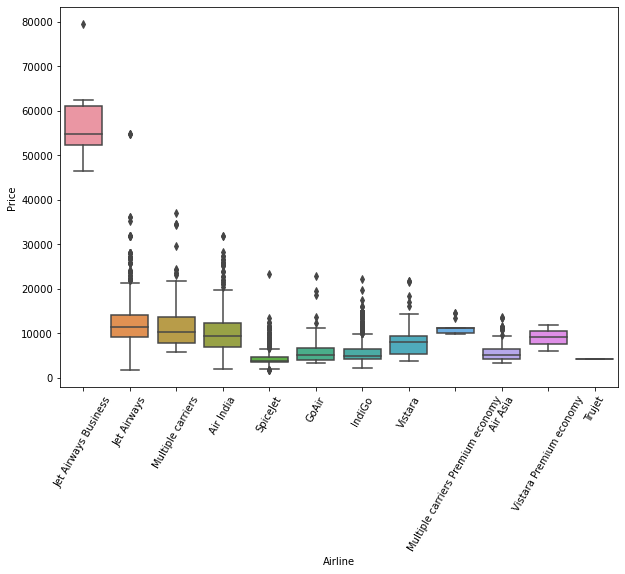

In [39]:
plt.figure(figsize=(10,7))
sns.boxplot(x="Airline",y="Price",data=df.sort_values("Price",ascending=False))
plt.xticks(rotation=60)
plt.show()

As we can see from the boxplot Jet Airways Buisness airline company has the most expensive flight price.

<AxesSubplot:xlabel='Total_Stops', ylabel='Price'>

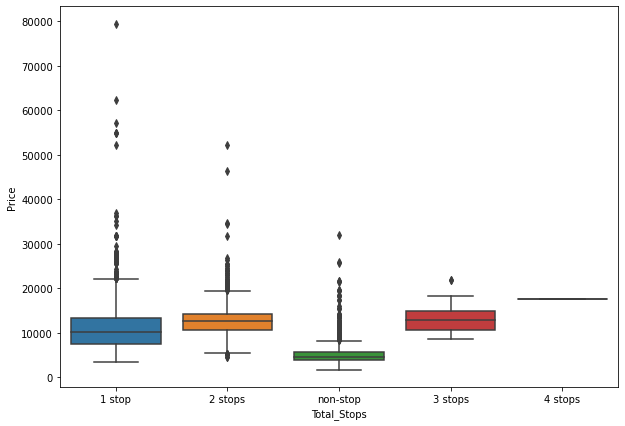

In [40]:
plt.figure(figsize=(10,7))
sns.boxplot(x="Total_Stops",y="Price",data=df.sort_values("Price",ascending=False))

There is no significant relationship between total stops and flight price.

### Feature Encoding

For feature encoding we will use one-hot encoding for nominal variables and label-encoding for ordinal variables.

In [42]:
# one hot-encoding
airline=pd.get_dummies(categorical["Airline"],drop_first=True)
airline.head()

,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [43]:
categorical["Source"].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

<AxesSubplot:xlabel='Source', ylabel='Price'>

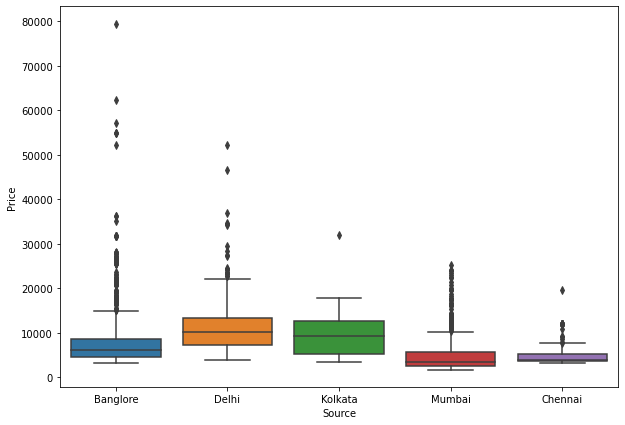

In [44]:
plt.figure(figsize=(10,7))
sns.boxplot(x="Source",y="Price",data=df.sort_values("Price",ascending=False))

In [45]:
source=pd.get_dummies(categorical["Source"],drop_first=True)
source.head()

,Chennai,Delhi,Kolkata,Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [46]:
categorical["Destination"].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

<AxesSubplot:xlabel='Destination', ylabel='Price'>

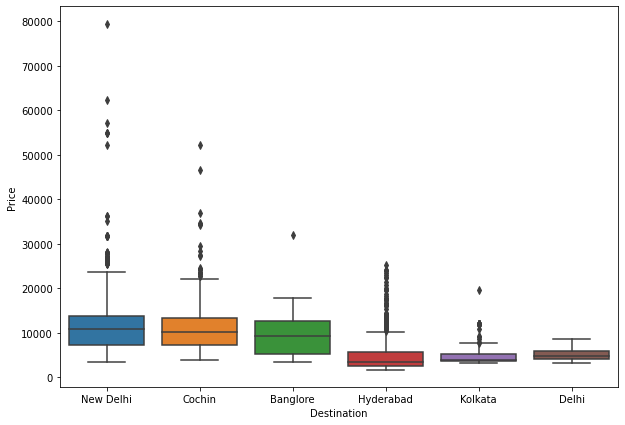

In [47]:
plt.figure(figsize=(10,7))
sns.boxplot(x="Destination",y="Price",data=df.sort_values("Price",ascending=False))

In [48]:
destination=pd.get_dummies(categorical["Destination"],drop_first=True)
destination.head()

,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [49]:
categorical["Route"]

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10682, dtype: object

As we can see, in "Route" column we have some marks which needs to be removed because our model only recognize numerical values.

In [50]:
categorical["Route_1"]=categorical["Route"].str.split("→").str[0]
categorical["Route_2"]=categorical["Route"].str.split("→").str[1]
categorical["Route_3"]=categorical["Route"].str.split("→").str[2]
categorical["Route_4"]=categorical["Route"].str.split("→").str[3]
categorical["Route_5"]=categorical["Route"].str.split("→").str[4]

In [51]:
categorical.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,BLR,DEL,NaN,NaN,NaN
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,CCU,IXR,BBI,BLR,NaN
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,DEL,LKO,BOM,COK,NaN
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,CCU,NAG,BLR,NaN,NaN
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,BLR,NAG,DEL,NaN,NaN


In [52]:
categorical=categorical.drop("Route",axis=1)

In [53]:
categorical.isnull().sum()

Airline                0
Source                 0
Destination            0
Total_Stops            0
Additional_Info        0
Route_1                0
Route_2                0
Route_3             3491
Route_4             9116
Route_5            10636
dtype: int64

We can see that we have a lot of flights that don't have third,fourth and fifth route. So we will replace null values with "None".

In [54]:
for i in ["Route_3","Route_4","Route_5"]:
    categorical[i]=categorical[i].fillna("None")

In [55]:
categorical.isnull().sum()

Airline            0
Source             0
Destination        0
Total_Stops        0
Additional_Info    0
Route_1            0
Route_2            0
Route_3            0
Route_4            0
Route_5            0
dtype: int64

In [56]:
#counting how many category we have
for i in categorical.columns:
    print("{}  has total {} categories".format(i,len(categorical[i].value_counts())))

Airline  has total 12 categories
Source  has total 5 categories
Destination  has total 6 categories
Total_Stops  has total 5 categories
Additional_Info  has total 10 categories
Route_1  has total 5 categories
Route_2  has total 45 categories
Route_3  has total 30 categories
Route_4  has total 14 categories
Route_5  has total 6 categories


In [57]:
from sklearn.preprocessing import LabelEncoder

In [58]:
encoder=LabelEncoder()

In [59]:
categorical.columns

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info',
       'Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5'],
      dtype='object')

In [60]:
for i in ['Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5']:
    categorical[i]=encoder.fit_transform(categorical[i])

In [61]:
categorical.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,non-stop,No info,0,13,29,13,5
1,Air India,Kolkata,Banglore,2 stops,No info,2,25,1,3,5
2,Jet Airways,Delhi,Cochin,2 stops,No info,3,32,4,5,5
3,IndiGo,Kolkata,Banglore,1 stop,No info,2,34,3,13,5
4,IndiGo,Banglore,New Delhi,1 stop,No info,0,34,8,13,5


In [62]:
categorical=categorical.drop("Additional_Info",axis=1)

In [63]:
categorical["Total_Stops"].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [64]:
dicti={'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}

In [65]:
categorical["Total_Stops"]=categorical["Total_Stops"].map(dicti)

In [66]:
categorical.head()

,Airline,Source,Destination,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,0,0,13,29,13,5
1,Air India,Kolkata,Banglore,2,2,25,1,3,5
2,Jet Airways,Delhi,Cochin,2,3,32,4,5,5
3,IndiGo,Kolkata,Banglore,1,2,34,3,13,5
4,IndiGo,Banglore,New Delhi,1,0,34,8,13,5


In [67]:
data=pd.concat([categorical,airline,source,destination,df[num_col]],axis=1)

In [68]:
data.head()

,Airline,Source,Destination,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Price,journey_month,journey_day,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_minutes
0,IndiGo,Banglore,New Delhi,0,0,13,29,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3897,3,24,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,2,25,1,3,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,3,32,4,5,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,2,34,3,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,0,34,8,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13302,1,3,16,50,21,35,4,45


In [69]:
data=data.drop(["Airline","Source","Destination"],axis=1)
data.head()

,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Price,journey_month,journey_day,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_minutes
0,0,0,13,29,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3897,3,24,22,20,1,10,2,50
1,2,2,25,1,3,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7662,1,5,5,50,13,15,7,25
2,2,3,32,4,5,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,13882,9,6,9,25,4,25,19,0
3,1,2,34,3,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6218,12,5,18,5,23,30,5,25
4,1,0,34,8,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13302,1,3,16,50,21,35,4,45


In [70]:
data.shape

(10682, 35)

In [71]:
def plot(df,col):
    fig,(ax1,ax2)=plt.subplots(2,1)
    sns.distplot(df[col],ax=ax1)
    sns.boxplot(df[col],ax=ax2)

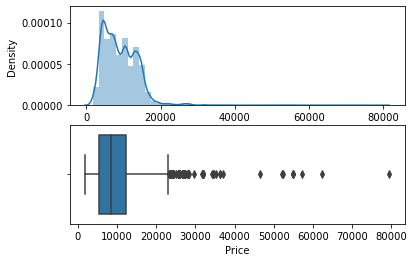

In [72]:
plot(data,"Price")

As we can see Price column is  right skewed so we need to take care of outliers. We will replace all values higher then 40 000 with median values.

In [73]:
data['Price']=np.where(data['Price']>=40000,data['Price'].median(),data['Price'])

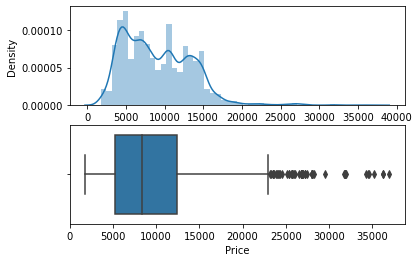

In [74]:
plot(data,"Price")

In [75]:
X=data.drop("Price",axis=1)
y=data["Price"]

In [76]:
from sklearn.feature_selection import mutual_info_classif

In [77]:
X.dtypes

Total_Stops                          int64
Route_1                              int64
Route_2                              int64
Route_3                              int64
Route_4                              int64
Route_5                              int64
Air India                            uint8
GoAir                                uint8
IndiGo                               uint8
Jet Airways                          uint8
Jet Airways Business                 uint8
Multiple carriers                    uint8
Multiple carriers Premium economy    uint8
SpiceJet                             uint8
Trujet                               uint8
Vistara                              uint8
Vistara Premium economy              uint8
Chennai                              uint8
Delhi                                uint8
Kolkata                              uint8
Mumbai                               uint8
Cochin                               uint8
Delhi                                uint8
Hyderabad  

In [78]:
mutual_info_classif(X,y)

array([2.15150172, 2.04531772, 2.76969121, 2.24699658, 1.51826416,
       0.71153828, 0.75370213, 0.0915632 , 0.66455418, 0.92646547,
       0.00612776, 0.57213966, 0.01267556, 0.33389912, 0.        ,
       0.20943995, 0.00297566, 0.18739477, 1.55681992, 0.8564646 ,
       0.29246404, 1.54248219, 0.40117323, 0.30542799, 0.16761046,
       0.36139313, 0.8427642 , 1.08363337, 1.42529462, 1.21999532,
       1.84494055, 1.53350892, 1.75336143, 1.08125457])

In [79]:
importance=pd.DataFrame(mutual_info_classif(X,y),index=X.columns)
importance

,0
Total_Stops,2.146060
Route_1,2.058391
Route_2,2.774403
Route_3,2.320403
Route_4,1.481021
Route_5,0.723043
Air India,0.743492
GoAir,0.096016
IndiGo,0.669596
Jet Airways,0.930849


In [80]:
importance.columns=["importance"]
importance.sort_values("importance",ascending=False)

,importance
Route_2,2.774403
Route_3,2.320403
Total_Stops,2.146060
Route_1,2.058391
Arrival_Time_hour,1.837405
Duration_hours,1.783694
Cochin,1.528955
Arrival_Time_minute,1.526501
Delhi,1.494655
Route_4,1.481021


In [81]:
from sklearn.model_selection import train_test_split

In [82]:
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.25)

In [83]:
from sklearn import metrics

In [80]:
def prediction(ml_model):
    model=ml_model.fit(train_X,train_y)
    print("Training Score: {}".format(model.score(train_X,train_y)) )
    predict=model.predict(test_X)
    print("Predictions are: \n {}".format(predict))
    print("\n")
    r2_score=metrics.r2_score(test_y,predict)
    print("R2 score is:  {}".format(r2_score))
    
    print("MAE is:",metrics.mean_absolute_error(test_y,predict))
    print("MSE is:",metrics.mean_squared_error(test_y,predict))
    print("RMSE is:",np.sqrt(metrics.mean_squared_error(test_y,predict)))
          
    sns.distplot(test_y-predict)

In [81]:
from sklearn.ensemble import RandomForestRegressor

Training Score: 0.9550316079917981
Predictions are: 
 [ 6567.24        5199.76       15344.82116667 ...  9287.89298413
  7558.8         4743.33333333]


R2 score is:  0.8197155949159772
MAE is: 1152.5740928025239
MSE is: 3538981.816224549
RMSE is: 1881.2181734781718


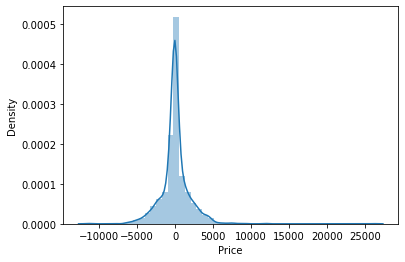

In [83]:
prediction(RandomForestRegressor())

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

Training Score: 0.618964903569865
Predictions are: 
 [ 9083.71750128  4880.50495081 12160.98407573 ... 14552.76076153
  8894.86130054  6512.70104459]


R2 score is:  0.605553282700596
MAE is: 1958.8041152907385
MSE is: 7742986.751080709
RMSE is: 2782.6222796277452


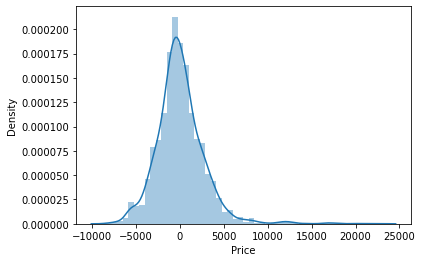

In [88]:
prediction(LinearRegression())

Training Score: 0.7755602934804139
Predictions are: 
 [ 7593.2  4930.  12965.  ...  9493.4 11711.6  5226. ]


R2 score is:  0.6642346495630955
MAE is: 1721.034968176713
MSE is: 6591071.863152378
RMSE is: 2567.3082914119173


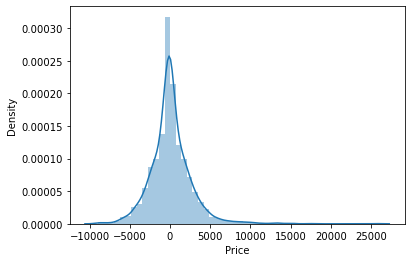

In [89]:
prediction(KNeighborsRegressor())

Training Score: 0.9693510248645132
Predictions are: 
 [ 6241.   5224.  16289.  ...  9134.5  7934.   4050. ]


R2 score is:  0.7213952014335925
MAE is: 1333.235136652939
MSE is: 5469010.564612608
RMSE is: 2338.591577127697


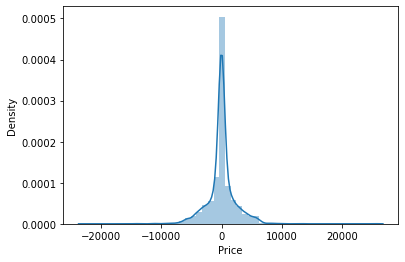

In [90]:
prediction(DecisionTreeRegressor())

In [97]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [98]:
rf=RandomForestRegressor()

In [95]:
# Number of trees in random forest
n_estimators=[int(x) for x in np.linspace(start=100,stop=1200,num=6)]

max_depth=[int(x) for x in np.linspace(start=5,stop=30,num=4)]

In [96]:
params={
    "n_estimators":n_estimators,
    "max_features":["auto","sqrt"],
    "max_depth":max_depth,
    "min_samples_split":[5,10,15,100]
    }

In [99]:
rs=RandomizedSearchCV(estimator=rf,param_distributions=params,cv=5,verbose=2,n_jobs=-1)

In [100]:
rs.fit(train_X,train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10, 15, 100],
                                        'n_estimators': [100, 320, 540, 760,
                                                         980, 1200]},
                   verbose=2)

In [101]:
predicted=rs.predict(test_X)

<AxesSubplot:xlabel='Price', ylabel='Density'>

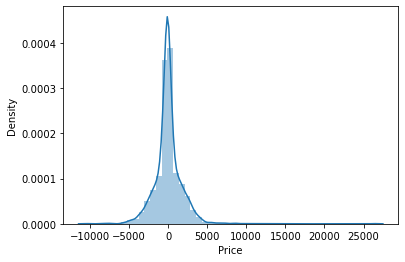

In [102]:
sns.distplot(test_y-predicted)

In [104]:
r2_score=metrics.r2_score(test_y,predicted)
r2_score

0.8446133014803282

If we compare our r2 score of RandomForest algorithm with and without hyperparameters optimization we can see that after parameter tuning we have better r2score for 2.5%.